# Decision Tree

This notebook implements a decision tree. In principle, at first, the root is chosen after the highest information gain. Then, this procedure is applied to all children of the root recursively.

In [1]:
import matplotlib.pyplot as plt
from Tree import Node, formatize, split_data
import numpy as np
import csv
import scipy.io as scio
import pandas as pd
import math
import random

## Toy Example

First, we are going to consider a decision tree with the example in the lecture slides. The data used can be seen in the following table.

In [2]:
reader = csv.reader(open("Toy.csv", "rt", encoding="utf8"), delimiter=',')
data = list(reader)
data = np.array(data)

n, d = np.shape(data)

pd_data = {}

for i in range(d):
    pd_data[data[0, i]] = list(data[1:, i])

df = pd.DataFrame(pd_data)
df

,Size,Humidity,Label
0,1,1,0
1,1.5,1,0
2,2,1.25,0
3,4,1,1
4,5,1,1
5,1.25,3,1
6,1.75,2.5,1
7,2,3.25,1
8,4,3,1
9,5.5,2.5,1


Visualized, it looks as follows:

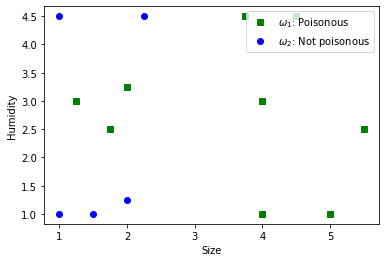

In [3]:
# remove the feature labels
data = data[1:, :].astype(float)

# split it into two classes for visualization
ind_1 = np.where(data[:, -1] == 1)[0]
ind_2 = np.where(data[:, -1] == 0)[0]
data_1 = np.take(data, ind_1, axis=0)
data_2 = np.take(data, ind_2, axis=0)

plt.plot(data_1[:, 0], data_1[:, 1], 'gs')
plt.plot(data_2[:, 0], data_2[:, 1], 'bo')
plt.xlabel('Size')
plt.ylabel('Humidity')
plt.legend(['$\omega_1$: Poisonous', '$\omega_2$: Not poisonous'])
plt.show()

As we can see in the plot, the bound $s_0 = 3$ for the size and the bounds $h_0 = 2$, $h_1 = 4$ for humidity would split the space into reasonable regions. You can however enter your own boundaries here below.
It is important that you enter the boundaries in ascending order!

In [4]:
s_sep = [3]    # [s_0]
h_sep = [2, 4] # [h_0, h_1]

Normally, the boundaries can be found automatically by sorting the data and inserting a boundary at every class change. For reasons of simplicity and visualization, we enter the boundaries manually here.

We create a root node and train it. The root then trains all of its children recursively.

In [5]:
n, d = np.shape(data)

separations = [s_sep, h_sep]

# create a root node with data 'data', minimum remaining values '1' and separations 'separations'.
min_rem_val = 1
root = Node(data, min_rem_val, separations)
root.train()

The class *Node* implements methods for computing entropy, information gain, the corresponding sets $S_\nu$ and finally $a^*$. The information gain for the default separations is the same as in the slides. Of course we can also compute it manually. The calculation of the entropy is quite easy, to find the correct sets $S_\nu$ recursively takes a lot of code. For the size and the humidity, we can however do it easily by hand.

In [6]:
# recall that the data matrix is given by the ['size', 'humidity', 'poisonous']

ind_s_0 = np.where(data[:, 0] <= s_sep[0])[0]
ind_s_1 = np.where(data[:, 0] > s_sep[0])[0]
s_size_0 = np.take(data, ind_s_0, axis=0)
s_size_1 = np.take(data, ind_s_1, axis=0)
S_nus_size = [s_size_0, s_size_1]

ind_h_0 = np.where(data[:, 1] <= h_sep[0])[0]
ind_h_1 = np.where(np.logical_and(data[:, 1] > h_sep[0], data[:, 1] <= h_sep[1]))[0]
ind_h_2 = np.where(data[:, 1] > h_sep[1])[0]
s_hdty_0 = np.take(data, ind_h_0, axis=0)
s_hdty_1 = np.take(data, ind_h_1, axis=0)
s_hdty_2 = np.take(data, ind_h_2, axis=0)
S_nus_hdty = [s_hdty_0, s_hdty_1, s_hdty_2]

def ig(S_nus):
        # in practice, we would have to get the S_nus here recursively
        # moreover, the root below would be replaced by self, the data by self.data
        h_nu = 0
        n, d = np.shape(data)

        for S_nu in S_nus:
            if S_nu is None:
                continue
            m, e = np.shape(S_nu)
            h_nu += (m/n)*root.entropy(S_nu)

        return root.entropy(data) - h_nu

print('Information gain for the size: ', ig(S_nus_size))
print('Information gain for the humidity: ', ig(S_nus_hdty))

Information gain for the size:  0.3948950998563654
Information gain for the humidity:  0.3078036035082494


In the following block, we check wheter the decision, we visualize the decision boundary.

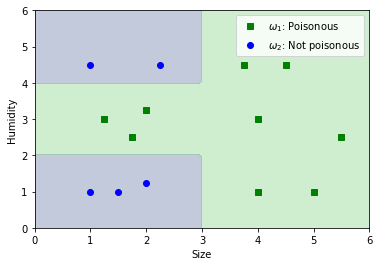

In [7]:
x = np.linspace(0, 6)
y = np.linspace(0, 6)

xm, ym = np.meshgrid(x, y)

n, m = np.shape(xm)
f = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        f[i, j] = root.classify(np.array([xm[i, j], ym[i, j]]))
        
plt.contourf(x, y, f, levels=[-0.5, 0.5, 1.5], alpha=0.3, origin = "image")
plt.xlabel('Size')
plt.ylabel('Humidity')
plt.plot(data_1[:, 0], data_1[:, 1], 'gs')
plt.plot(data_2[:, 0], data_2[:, 1], 'bo')
plt.legend(['$\omega_1$: Poisonous', '$\omega_2$: Not poisonous'])
plt.show()

You can now enter your own example of a mushroom which is then classified as poisonous or non-poisonous.

In [8]:
size = float(input('Enter size: '))
hum = float(input('Enter Humidity: '))

omega = root.classify(np.array([size, hum]))

if omega == 0:
    print('Not poisonous')
elif omega == 1:
        print('Poisonous')

Enter size: 2
Enter Humidity: 2
Not poisonous


## Titanic Dataset

Now we are going to test the decision tree on a data set of titanic passengers. The data set is available on

https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html

The data used is passenger class, sex, age, number of siblings or sprouses aboard, number of parents or children aboard and the fare they paid.

Given all that, we want do predict wheter a person will survive the sinking. The data set looks as follows:

In [9]:
reader = csv.reader(open("titanic_train.csv", "rt", encoding="utf8"), delimiter=',')
training_data = list(reader)
training_data_from_file = np.array(training_data)

reader = csv.reader(open("titanic_test.csv", "rt", encoding="utf8"), delimiter=',')
test_data = list(reader)
test_data_from_file = np.array(test_data)

n, d = np.shape(training_data)

pd_data = {}

for i in range(d):
    pd_data[training_data_from_file[0, i]] = list(training_data_from_file[1:, i])
    
df = pd.DataFrame(pd_data)
df

,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Survived
0,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38,1,0,71.2833,1
1,3,Miss. Laina Heikkinen,female,26,0,0,7.925,1
2,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,53.1,1
3,3,Mr. James Moran,male,27,0,0,8.4583,0
4,1,Mr. Timothy J McCarthy,male,54,0,0,51.8625,0
...,...,...,...,...,...,...,...,...
683,2,Mrs. William (Imanita Parrish Hall) Shelley,female,25,0,1,26,1
684,3,Mr. Johann Markun,male,33,0,0,7.8958,0
685,3,Mr. Henry Jr Sutehall,male,25,0,0,7.05,0
686,2,Rev. Juozas Montvila,male,27,0,0,13,0


We do have to format the data by assigning a value to the sex as well as to remove the first row with the labels of the features. This is done in the formatize method.

Afterwards, we train a tree with this data set and then test the performance on the test set. You can enter the number of remaining values at which we stop splitting and assign the majority class to the currently considered node.

We are going to use the following separation, but you can also play around with it!

In [10]:
class_sep = [1, 2, 3]
sex_sep = [0.5] 
age_sep = [9, 18, 25, 38, 47, 56, 65, 70]
siblings_sep = [1, 2, 3, 4]
parents_sep = [1, 2, 3, 4]
fare_sep = [10*i for i in range(1, 10)]

separations = [class_sep, sex_sep, age_sep, siblings_sep, parents_sep, fare_sep]

In [11]:
# keep the features for further issues
features = training_data_from_file[0, :]
# remove the names and the labels
features = np.delete(features, 1)
features = np.delete(features, -1)

# create a nice np.array
training_data = formatize(training_data_from_file)
test_data = formatize(test_data_from_file)

# Play around with the number of minimal remaining passengers!
# note that the lower the number, the higher the danger of overfitting
min_passengers = int(input('Enter the number of minimal remaining values: '))
root_2 = Node(training_data, min_passengers, separations)
root_2.train()

n, d = np.shape(test_data)

corr = 0

for i in range(n):
    if test_data[i, d-1] == root_2.classify(np.array(test_data[i, :d-1])):
        corr += 1

print('Classified', corr, 'out of', n, 'examples correctly.')

Enter the number of minimal remaining values: 10
Classified 160 out of 200 examples correctly.


We can also print the information gain for the first node:

In [12]:
for i in range(len(features)):
    print('Information gain for', features[i] + ': ', root_2.ig(i)[0])

Information gain for Pclass:  0.07188373957410232
Information gain for Sex:  0.22604658073492212
Information gain for Age:  0.027011478334324823
Information gain for Siblings/Spouses Aboard:  0.009499541148886848
Information gain for Parents/Children Aboard:  0.013555332904855888
Information gain for Fare:  0.09484279915454985


The full tree looks like as follows. The features are always ordered in ascending order.

In [13]:
print(root_2.to_string(features, depth=0))

Sex
|--Age
|  |--Siblings/Spouses Aboard
|  |--Fare
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |--Fare
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |--Fare
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |  |  |--Parents/Children Aboard
|  |--Fare
|  |  |--Pclass
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |  |--Pclass
|  |--Fare
|  |--Fare
|--Pclass
|  |--Parents/Children Aboard
|  |--Age
|  |  |--Fare
|  |  |--Fare
|  |  |  |--Siblings/Spouses Aboard
|  |  |  |  |--Parents/Children Aboard
|  |--Age
|  |  |--Siblings/Spouses Aboard
|  |  |-

Check whether you would (likely) have survived the tianic catastrophe! If you do not know your ticket fare or anything else from the data you are asked to enter below, just leave the field blank. The classification function assigns, if needed, the most common value to that feature.

In [14]:
try:
    p_class = float(input('Enter passenger class: '))
except:
    p_class = None

sex = input('Enter sex (m/f): ')

try:
    age = float(input('Enter age: '))
except:
    age = None
try:
    siblings = float(input('Enter the number of siblings/sprouses aboard: '))
except:
    siblings = None
try:
    parents = float(input('Enter the number of parents or childrens aboard: '))
except:
    parents = None
try:
    fare = float(input('Enter the ticket fare paid: '))
except:
    fare = None

if sex == 'm':
    sex_number = 0
elif sex == 'f':
    sex_number = 1
else:
    sex_number = None
    
print()
passenger = np.array([p_class, sex_number, age, siblings, parents, fare])

if(root_2.classify(passenger)) == 1:
    print('Likely survives.')
else:
    print('Likely dies.')

Enter passenger class: 1
Enter sex (m/f): 1
Enter age: 
Enter the number of siblings/sprouses aboard: 
Enter the number of parents or childrens aboard: 
Enter the ticket fare paid: 

Likely survives.


To see that the parameter of the minimum remaining effects the performance of the decision tree, we train a tree with different parameters and consider the performance.

k = 10
k = 20
k = 30
k = 40
k = 50


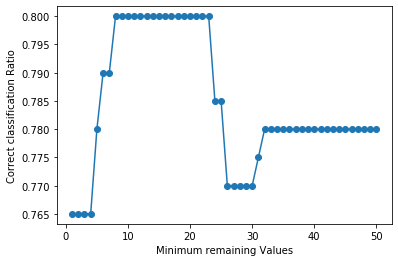

In [15]:
ratios = []

# might take some time...
for k in range(1, 51):
    if k % 10 == 0:
        print('k =', k)
    root_2 = Node(training_data, k, separations)
    root_2.train()
    
    corr = 0
    n, d = np.shape(test_data)
    for i in range(n):
        if test_data[i, d-1] == root_2.classify(np.array(test_data[i, :d-1])):
            corr += 1
    
    ratios.append(corr/n)

x = [i for i in range(1, 51)]

plt.plot(x, ratios, '-o')
plt.xlabel('Minimum remaining Values')
plt.ylabel('Correct classification Ratio')
plt.show()

## Random Forest

Finally, we are going to implement a random decision tree forest. You can enter a number of $T$ trees to be grown,
and the size $n$ of the training data used of each tree.

Then, $T$ trees are consequtively trained using randomly chosen $n$ samples out of the training data. For classification, we throw and element into every tree and then classify it to the most common class. 

Note that there is also a possibility to learn a weighted linear function or some even more complicated stuff. This however requires to have a second, final test set because the first test set is used for learning the weights.

In [16]:
number_of_trees = int(input('Enter the number of trees: '))
# training_size_ratio = input('Enter the size of the training sets (0.5 mean half of the original set): ')
# training_size = int(float(training_size_ratio) * np.shape(training_data)[0])
training_size = np.shape(training_data)[0] // number_of_trees
min_rem_values = int(input('Enter the number of minimum remaining values: '))

n, d = np.shape(training_data)

roots = []
for i in range(number_of_trees):
    training_data_prime = training_data.copy()
    # Attention: split_data takes the size of the test set!
    training_data_prime, _ = split_data(training_data_prime, n - training_size)
    
    roots.append(Node(training_data_prime, min_rem_values, separations))
    roots[-1].train()

# classify everything
cfications = []

n, d = np.shape(test_data)

for i in range(n):
    score = 0
    for root in roots:
        score += root.classify(np.array(test_data[i, :d-1]))
    score /= number_of_trees
    if score <= 0.5:
        cfications.append(0)
    else:
        cfications.append(1)

# check the performance
corr = 0
for i in range(n):
    if cfications[i] == test_data[i, d-1]:
        corr += 1

print ('Classified ', corr, 'out of ', n, 'examples correctly', 100*corr/n,'%')

Enter the number of trees: 10
Enter the number of minimum remaining values: 100
Classified  129 out of  200 examples correctly 64.5 %
